In [1]:
import numpy as np
import pandas as pd   
import os
from pathlib import Path
import glob
import json
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import nltk
import cv2
import matplotlib.pyplot as plt
import random

physical_devices = tf.config.list_physical_devices('GPU') 
print("Number of GPUs :", len(physical_devices)) 
print("Tensorflow GPU :",tf.test.is_built_with_cuda())
if len(physical_devices)>0:
    device="/GPU:0"
else:
    device="/CPU:0"

Number of GPUs : 1
Tensorflow GPU : True


In [2]:
def load_data(N, mode='train'):
    with open(f'clevr/CLEVR_v1/questions/CLEVR_{mode}_questions.json') as f:
        data = json.load(f)
        data_set_size = len(data['questions'])
        records = []
        for k in np.random.uniform(0, data_set_size, N).astype(int):
            i = data['questions'][k]
            temp=[]
            for path in glob.glob(f'clevr/CLEVR_v1/images/{mode}/'+i['image_filename']): 
                temp.append(path)
            temp.append(i['question'])
            temp.append(i['answer'])
            records.append(temp)
    labels=['Path','Question','Answer']
    return pd.DataFrame.from_records(records, columns=labels)

In [3]:
train_df = load_data(70000, 'train')
val_df = load_data(15000, 'val')

In [4]:
def tokenize_qs(questions, tokenizer):
    res = set()
    for question in questions:
        res.update(tokenizer.tokenize(question))
    return res
    
tokenizer = tfds.deprecated.text.Tokenizer()

answer_set = set(np.append(train_df['Answer'].unique(),val_df['Answer'].unique()))
question_set = set(np.append(train_df['Question'].unique(),val_df['Question'].unique()))
vocab_set = tokenize_qs(question_set, tokenizer) | answer_set
    
encoder=tfds.deprecated.text.TokenTextEncoder(vocab_set)
answer_encoder=tfds.deprecated.text.TokenTextEncoder(answer_set)

In [5]:
BATCH_SIZE=128
IMG_SIZE=(128,128)


def encode_fn(text):
    return np.array(encoder.encode(text.numpy()))

def answer_encode_fn(text):
    return np.array(answer_encoder.encode(text.numpy()))

def preprocess(ip,ans):
    img,ques=ip
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img,channels=3)
    img=tf.image.resize(img,IMG_SIZE)
    img=tf.math.divide(img, 255)# 
    ques=tf.py_function(encode_fn,inp=[ques],Tout=tf.int32)
    paddings = [[0, 50-tf.shape(ques)[0]]]
    ques = tf.pad(ques, paddings, 'CONSTANT', constant_values=0)
    ques.set_shape([50])
    
    ans=tf.py_function(answer_encode_fn,inp=[ans],Tout=tf.int32)
    ans.set_shape([1])
    
    return (img,ques),ans
    
def create_pipeline(dataframe):
    raw_df=tf.data.Dataset.from_tensor_slices(((dataframe['Path'],dataframe['Question']),dataframe['Answer']))
    df=raw_df.map(preprocess)
    df=df.batch(BATCH_SIZE)
    return df

train_dataset=create_pipeline(train_df)
validation_dataset=create_pipeline(val_df)

In [87]:
CNN_Input=tf.keras.layers.Input(shape=(128,128,3),name='image_input')

mobilenetv2=tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(128,128,3), alpha=1.0, include_top=False,
                                                      weights='imagenet', input_tensor=CNN_Input)

CNN_model=tf.keras.models.Sequential()
CNN_model.add(CNN_Input)
CNN_model.add(mobilenetv2)
CNN_model.add(tf.keras.layers.GlobalAveragePooling2D())



#Creating the RNN model for text processing
RNN_model=tf.keras.models.Sequential()

RNN_Input=tf.keras.layers.Input(shape=(50),name='text_input')
RNN_model.add(RNN_Input)
RNN_model.add(tf.keras.layers.Embedding (len(vocab_set)+1,256))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,stateful=False,return_sequences=True,recurrent_initializer='glorot_uniform')))
RNN_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,stateful=False,return_sequences=False,recurrent_initializer='glorot_uniform')))


concat=tf.keras.layers.concatenate([CNN_model.output,RNN_model.output])
dense_out=tf.keras.layers.Dense(len(answer_set) + 1,activation='softmax',name='output')(concat)

model = tf.keras.Model(inputs=[CNN_Input,RNN_Input],
                    outputs=dense_out)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 50, 256)      25856       text_input[0][0]                 
__________________________________________________________________________________________________
image_input (InputLayer)        [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
bidirectional_36 (Bidirectional (None, 50, 512)      1050624     embedding_12[0][0]               
______________________________________________________________________________________

In [88]:
epochs=30
with tf.device(device):
       history =  model.fit(train_dataset,
                  validation_data=validation_dataset,
                  epochs=epochs)

Epoch 1/30
3907/3907 [==============================] - 4105s 1s/step - loss: 1.0723 - accuracy: 0.4407 - val_loss: 1.0216 - val_accuracy: 0.4509
Epoch 2/30
3907/3907 [==============================] - 3491s 893ms/step - loss: 0.9453 - accuracy: 0.4805 - val_loss: 1.0658 - val_accuracy: 0.4539
Epoch 3/30
3907/3907 [==============================] - 3494s 894ms/step - loss: 0.9150 - accuracy: 0.5022 - val_loss: 0.9841 - val_accuracy: 0.4677
Epoch 4/30
3907/3907 [==============================] - 3489s 893ms/step - loss: 0.9024 - accuracy: 0.5097 - val_loss: 0.9193 - val_accuracy: 0.5076
Epoch 5/30
3907/3907 [==============================] - 3494s 894ms/step - loss: 0.8955 - accuracy: 0.5130 - val_loss: 0.9107 - val_accuracy: 0.5051
Epoch 6/30
3907/3907 [==============================] - 3487s 892ms/step - loss: 0.8883 - accuracy: 0.5172 - val_loss: 0.9080 - val_accuracy: 0.5089
Epoch 7/30
3907/3907 [==============================] - 3489s 893ms/step - loss: 0.8824 - accuracy: 0.5196 - 

In [ ]:
losses = pd.DataFrame(history.history)

<AxesSubplot:>

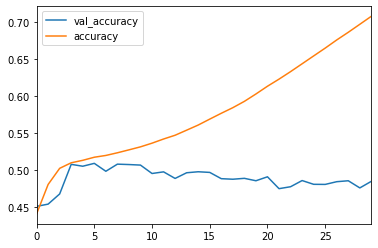

In [ ]:
losses[['val_accuracy', 'accuracy']].plot()

<AxesSubplot:>

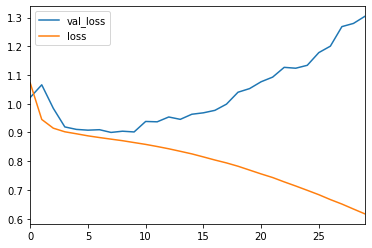

In [ ]:
losses[['val_loss', 'loss']].plot()

In [ ]:
import datetime

date_str = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
val_accuracy = losses[['val_accuracy']].values[-1][0]
date_str = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
checkpoint_path = f"models/mobile-{date_str}-{val_accuracy}-{epochs}"
model.save(checkpoint_path)


INFO:tensorflow:Assets written to: models/mobile-2021-05-18_06:00:19-0.48473334312438965-30/assets


In [ ]:
# model = tf.keras.models.load_model(checkpoint_path)